In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

In [2]:
from astropy.table import Table
mock = Table()

dirname = "/Volumes/simulation_data_2018/protoDC2_v4p6_lf_calibration_data/individual_columns_v4p5"
import os
basename = "{0}_v4.5.npy"
mock['redshift'] = np.load(os.path.join(dirname, basename.format('redshift')))
mock['mstar'] = np.load(os.path.join(dirname, basename.format('mstar')))
mock['mag_r'] = np.load(os.path.join(dirname, basename.format('mag_r')))
mock['mag_g_obs'] = np.load(os.path.join(dirname, basename.format('mag_g_obs')))
mock['mag_r_obs'] = np.load(os.path.join(dirname, basename.format('mag_r_obs')))
mock['mag_i_obs'] = np.load(os.path.join(dirname, basename.format('mag_i_obs')))
mock['upid'] = np.load(os.path.join(dirname, basename.format('upid')))
mock['mag_r_kcorrect'] = mock['mag_r_obs'] - mock['mag_r']


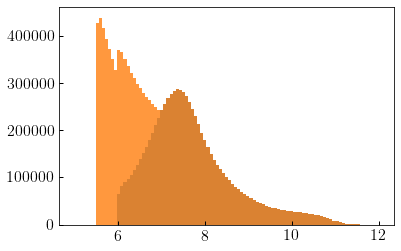

In [57]:
from scipy.stats import powerlaw
num_new_gals = int(5e6)
fake_mstar = 10**((1 - powerlaw.rvs(2, size=num_new_gals))*1.5 + 5.5)

mock_mask = mock['mstar'] < 10**7
# mock_mask *= mock['redshift'] > 0.5
num_cutmock = np.count_nonzero(mock_mask)

fake_galaxies = Table()
for key in mock.keys():
    fake_galaxies[key] = np.zeros(num_new_gals)
fake_galaxies['mstar'] = fake_mstar
fake_galaxies['upid'] = -1

_a = np.arange(num_cutmock)
idx = np.random.choice(_a, replace=True, size=num_new_gals)

fake_galaxies['redshift'] = mock['redshift'][mock_mask][idx]
fake_galaxies['mag_r_kcorrect'] = mock['mag_r_kcorrect'][mock_mask][idx]

from astropy.table import vstack
newmock = vstack((mock, fake_galaxies))

fig, ax = plt.subplots(1, 1)

logsm_bins = np.linspace(5, 12, 100)

__=ax.hist(np.log10(mock['mstar']), bins=logsm_bins, alpha=0.8)
__=ax.hist(np.log10(newmock['mstar']), bins=logsm_bins, alpha=0.8)

In [58]:
# fig, ax = plt.subplots(1, 1)

# __=ax.hist(fake_galaxies['redshift'], bins=50)


In [85]:
# newmock = Table(np.copy(mock))

from cosmodc2.sdss_colors.broken_powerlaw_magr import magr_monte_carlo

# kwargs_backup = dict(gamma_boost_table=(0., 0., -0.25, -0.5, -0.75, -1.))
kwargs = dict(gamma_boost_table=(0., 0., -0.25, -0.5, -0.75, -1.),
             magr_at_m1_boost_table=(0., 0., 0., 0.25, 0.3, 0.35))

newmock['mag_r'] = magr_monte_carlo(
    newmock['mstar'], newmock['upid'], newmock['redshift'], **kwargs)
newmock['mag_r_obs'] = newmock['mag_r_kcorrect'] + newmock['mag_r']


from cosmodc2.sdss_colors.broken_powerlaw_magr import default2_m1_z0, default2_magr_at_m1_z0
from cosmodc2.sdss_colors.broken_powerlaw_magr import default2_beta_z0, default2_gamma_z0

kwargs2 = dict(m1_z0=default2_m1_z0, magr_at_m1_z0=default2_magr_at_m1_z0, 
               beta_z0=default2_beta_z0, gamma_z0=default2_gamma_z0,
              gamma_boost_table=(0., 0., -0.25, -0.5, -0.75, -1.),
              beta_boost_table=(0., 0., 0.05, 0.08, 0.12, 0.2), 
              magr_at_m1_boost_table=(0., 0., 0., 0.15, 0.2, 0.3))

newmock['new_mag_r'] = magr_monte_carlo(
    newmock['mstar'], newmock['upid'], newmock['redshift'], **kwargs2)
newmock['new_mag_r_obs'] = newmock['mag_r_kcorrect'] + newmock['new_mag_r']


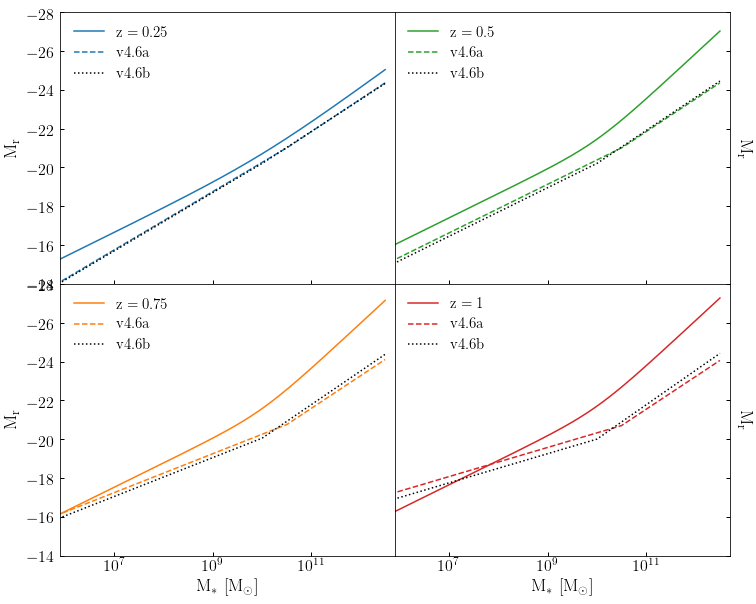

In [86]:
from cosmodc2.sdss_colors.broken_powerlaw_magr import median_magr_from_mstar
from cosmodc2.sdss_colors.analytical_magr import (
    median_magr_from_mstar as v4p5_median_magr_from_mstar)

npts = int(1e3)
mstar = np.logspace(5.8, 12.5, npts)
upid = np.zeros_like(mstar) - 1
_z = np.zeros(npts)

# ### default relation used in v4.5
mr_z0p0 = v4p5_median_magr_from_mstar(mstar, upid, _z + 0.0)
mr_z0p25 = v4p5_median_magr_from_mstar(mstar, upid, _z + 0.25)
mr_z0p5 = v4p5_median_magr_from_mstar(mstar, upid, _z + 0.5)
mr_z0p75 = v4p5_median_magr_from_mstar(mstar, upid, _z + .75)
mr_z1p0 = v4p5_median_magr_from_mstar(mstar, upid, _z + 1.0)

### new relation for in v4.6a
mr_z0p0_alt = median_magr_from_mstar(mstar, upid, _z + 0.0, **kwargs)
mr_z0p25_alt = median_magr_from_mstar(mstar, upid, _z + 0.25, **kwargs)
mr_z0p5_alt = median_magr_from_mstar(mstar, upid, _z + 0.5, **kwargs)
mr_z0p75_alt = median_magr_from_mstar(mstar, upid, _z + 0.75, **kwargs)
mr_z1p0_alt = median_magr_from_mstar(mstar, upid, _z + 1.0, **kwargs)

### new relation for in v4.6b
mr_z0p0_alt2 = median_magr_from_mstar(mstar, upid, _z + 0.0, **kwargs2)
mr_z0p25_alt2 = median_magr_from_mstar(mstar, upid, _z + 0.25, **kwargs2)
mr_z0p5_alt2 = median_magr_from_mstar(mstar, upid, _z + 0.5, **kwargs2)
mr_z0p75_alt2 = median_magr_from_mstar(mstar, upid, _z + 0.75, **kwargs2)
mr_z1p0_alt2 = median_magr_from_mstar(mstar, upid, _z + 1.0, **kwargs2)


fig, _axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4

ax2.yaxis.set_label_position("right")  #  y-labels on the right
ax2.yaxis.tick_right()  #  y-ticks on the right
ax4.yaxis.set_label_position("right")  #  y-labels on the right
ax4.yaxis.tick_right()  #  y-ticks on the right

for ax in axes:
    xscale = ax.set_xscale('log')
    ylim = ax.set_ylim(-14, -28)
    xlim = ax.set_xlim(8e5, 5e12)

    
# __=ax1.plot(10**logsm_mids, mr_z0p25, color=mblue, label=r'${\rm z=0.25}$')
__=ax1.plot(mstar, mr_z0p25, color=mblue, label=r'${\rm z=0.25}$')
__=ax1.plot(mstar, mr_z0p25_alt, '--', color=mblue, label=r'${\rm v4.6a}$')
__=ax1.plot(mstar, mr_z0p25_alt2, ':', color='k', label=r'${\rm v4.6b}$')

# __=ax2.plot(10**logsm_mids, mr_z0p5, color=mgreen, label=r'${\rm z=0.5}$')
__=ax2.plot(mstar, mr_z0p5, color=mgreen, label=r'${\rm z=0.5}$')
__=ax2.plot(mstar, mr_z0p5_alt, '--', color=mgreen, label=r'${\rm v4.6a}$')
__=ax2.plot(mstar, mr_z0p5_alt2, ':', color='k', label=r'${\rm v4.6b}$')

# __=ax3.plot(10**logsm_mids, mr_z0p75, color=morange, label=r'${\rm z=0.75}$')
__=ax3.plot(mstar, mr_z0p75, color=morange, label=r'${\rm z=0.75}$')
__=ax3.plot(mstar, mr_z0p75_alt, '--', color=morange, label=r'${\rm v4.6a}$')
__=ax3.plot(mstar, mr_z0p75_alt2, ':', color='k', label=r'${\rm v4.6b}$')

# __=ax4.plot(10**logsm_mids, mr_z1p0, color=mred, label=r'${\rm z=1}$')
__=ax4.plot(mstar, mr_z1p0, color=mred, label=r'${\rm z=1}$')
__=ax4.plot(mstar, mr_z1p0_alt, '--', color=mred, label=r'${\rm v4.6a}$')
__=ax4.plot(mstar, mr_z1p0_alt2, ':', color='k', label=r'${\rm v4.6b}$')

    
for ax in axes:
    leg = ax.legend()
    
xlabel3 = ax3.set_xlabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
xlabel4 = ax4.set_xlabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
ylabel1 = ax1.set_ylabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm M_{r}}$', rotation=-90, labelpad=20)
ylabel3 = ax3.set_ylabel(r'${\rm M_{r}}$')
ylabel4 = ax4.set_ylabel(r'${\rm M_{r}}$', rotation=-90, labelpad=20)


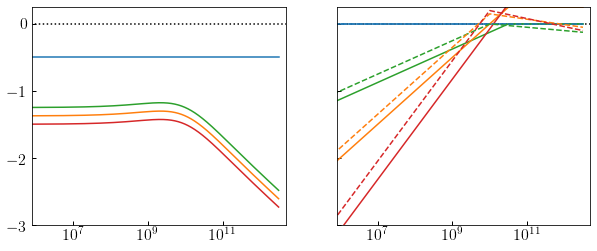

In [87]:
v4p5_mr_diff_z0p25 = mr_z0p25 - mr_z0p0
v4p5_mr_diff_z0p5 = mr_z0p5 - mr_z0p0
v4p5_mr_diff_z0p75 = mr_z0p75 - mr_z0p0
v4p5_mr_diff_z1p0 = mr_z1p0- mr_z0p0

v4p6a_mr_diff_z0p25 = mr_z0p25_alt - mr_z0p0_alt
v4p6a_mr_diff_z0p5 = mr_z0p5_alt - mr_z0p0_alt
v4p6a_mr_diff_z0p75 = mr_z0p75_alt - mr_z0p0_alt
v4p6a_mr_diff_z1p0 = mr_z1p0_alt- mr_z0p0_alt

v4p6b_mr_diff_z0p25 = mr_z0p25_alt2 - mr_z0p0_alt2
v4p6b_mr_diff_z0p5 = mr_z0p5_alt2 - mr_z0p0_alt2
v4p6b_mr_diff_z0p75 = mr_z0p75_alt2 - mr_z0p0_alt2
v4p6b_mr_diff_z1p0 = mr_z1p0_alt2 - mr_z0p0_alt2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
xscale = ax1.set_xscale('log')
xscale2 = ax2.set_xscale('log')
ylim = ax1.set_ylim(-3, 0.25)
xlim = ax1.set_xlim(8e5, 5e12)

__=ax1.plot(np.logspace(0, 30, 100), np.zeros(100), ':', color='k')
__=ax1.plot(mstar, v4p5_mr_diff_z0p25, color=mblue)
__=ax1.plot(mstar, v4p5_mr_diff_z0p5, color=mgreen)
__=ax1.plot(mstar, v4p5_mr_diff_z0p75, color=morange)
__=ax1.plot(mstar, v4p5_mr_diff_z1p0, color=mred)

__=ax2.plot(np.logspace(0, 30, 100), np.zeros(100), ':', color='k')
__=ax2.plot(mstar, v4p6a_mr_diff_z0p25, color=mblue)
__=ax2.plot(mstar, v4p6a_mr_diff_z0p5, color=mgreen)
__=ax2.plot(mstar, v4p6a_mr_diff_z0p75, color=morange)
__=ax2.plot(mstar, v4p6a_mr_diff_z1p0, color=mred)

__=ax2.plot(mstar, v4p6b_mr_diff_z0p25, '--', color=mblue)
__=ax2.plot(mstar, v4p6b_mr_diff_z0p5, '--', color=mgreen)
__=ax2.plot(mstar, v4p6b_mr_diff_z0p75, '--', color=morange)
__=ax2.plot(mstar, v4p6b_mr_diff_z1p0, '--', color=mred)


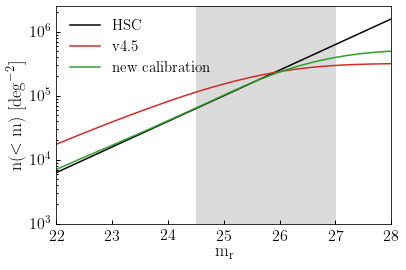

In [88]:
def dndmag(observed_flux, flux_bins=np.linspace(22, 28.5, 50), sky_area=25.):
    counts = np.array([np.count_nonzero(observed_flux < x) for x in flux_bins])
    return counts/float(sky_area), flux_bins

dndmag_v4p5, magr_obs_bins = dndmag(mock['mag_r_obs'])
dndmag_v4p6a, magr_obs_bins = dndmag(newmock['mag_r_obs'])
dndmag_v4p6b, magr_obs_bins = dndmag(newmock['new_mag_r_obs'])

fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
x1 = np.zeros(100) + 24.5
x2 = np.zeros(100) + 27
y = np.logspace(1, 10, 100)

__=ax.fill_betweenx(y, x1, x2, alpha=0.8, color='lightgray')

c0_hsc_r, c1_hsc_r = -5, 0.4
hsc_dndmagr_abscissa = np.linspace(20, 30, 100)
hsc_dndmagr_ordinates = 10**(c0_hsc_r + c1_hsc_r*hsc_dndmagr_abscissa)
__=ax.plot(hsc_dndmagr_abscissa, hsc_dndmagr_ordinates, label=r'${\rm HSC}$', color='k')

__=ax.plot(magr_obs_bins, dndmag_v4p5, label=r'${\rm v4.5}$', color=mred)
# __=ax.plot(magr_obs_bins, dndmag_v4p6a, label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax.plot(magr_obs_bins, dndmag_v4p6a, label=r'${\rm new\ calibration}$', color=mgreen)
# __=ax.plot(magr_obs_bins, dndmag_v4p6b, label=r'${\rm protoDC2\ v4.6b}$', color=mblue)

xlabel = ax.set_xlabel(r'${\rm m_{r}}$')
ylabel = ax.set_ylabel(r'${\rm n(<m)\ [deg^{-2}]}$')
legend = ax.legend()
ylim = ax.set_ylim(1e3, 2.5e6)
xlim = ax.set_xlim(22, 28)

figname = 'hsc_dndmag_v4p5_vs_v4p6.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

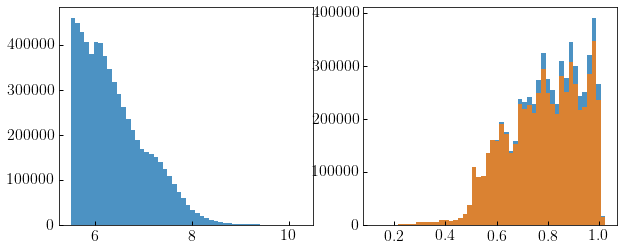

In [89]:
mask = newmock['mag_r_obs'] > 26
mask *= newmock['mag_r_obs'] < 28

mask2 = newmock['mstar'] < 10**7.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

__=ax1.hist(np.log10(newmock['mstar'][mask]), bins=50, alpha=0.8)

__=ax2.hist(newmock['redshift'][mask], bins=50, alpha=0.8)
__=ax2.hist(newmock['redshift'][mask & mask2], bins=50, alpha=0.8)


In [90]:
import os
deep2_dirname = "/Users/aphearin/work/repositories/python/cosmodc2/cosmodc2/data"

X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_22.txt"))
deep2_dndz_r22_redshift, deep2_dndz_r22_fit = X[:, 0], X[:, 1]
X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_23.txt"))
deep2_dndz_r23_redshift, deep2_dndz_r23_fit = X[:, 0], X[:, 1]
X = np.loadtxt(os.path.join(deep2_dirname, "deep2_dndz_rband_lt_24.txt"))
deep2_dndz_r24_redshift, deep2_dndz_r24_fit = X[:, 0], X[:, 1]

redshift_bins = np.linspace(0, 1, 15)
redshift_mids = 0.5*(redshift_bins[:-1] + redshift_bins[1:])

mask22 = mock['mag_r_obs'] < 22
mask23 = mock['mag_r_obs'] < 23
mask24 = mock['mag_r_obs'] < 24

pdc2_v4p5_dndz_r22, __ = np.histogram(
    mock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p5_dndz_r23, __ = np.histogram(
    mock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p5_dndz_r24, __ = np.histogram(
    mock['redshift'][mask24], density=True, bins=redshift_bins)


mask22 = newmock['mag_r_obs'] < 22
mask23 = newmock['mag_r_obs'] < 23
mask24 = newmock['mag_r_obs'] < 24

pdc2_v4p6a_dndz_r22, __ = np.histogram(
    newmock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p6a_dndz_r23, __ = np.histogram(
    newmock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p6a_dndz_r24, __ = np.histogram(
    newmock['redshift'][mask24], density=True, bins=redshift_bins)

mask22 = newmock['new_mag_r_obs'] < 22
mask23 = newmock['new_mag_r_obs'] < 23
mask24 = newmock['new_mag_r_obs'] < 24

pdc2_v4p6b_dndz_r22, __ = np.histogram(
    newmock['redshift'][mask22], density=True, bins=redshift_bins)
pdc2_v4p6b_dndz_r23, __ = np.histogram(
    newmock['redshift'][mask23], density=True, bins=redshift_bins)
pdc2_v4p6b_dndz_r24, __ = np.histogram(
    newmock['redshift'][mask24], density=True, bins=redshift_bins)


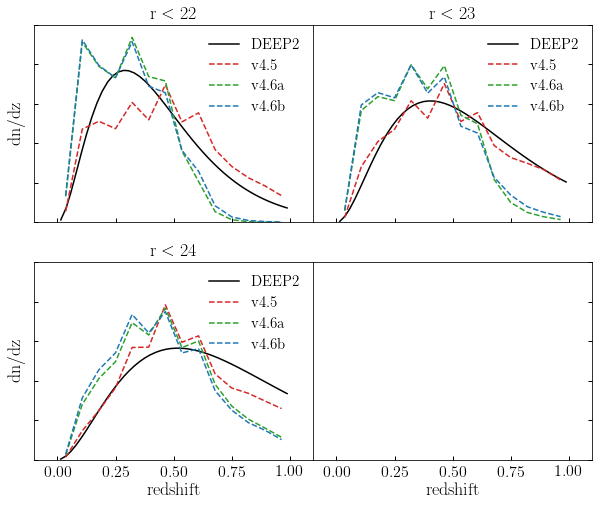

In [91]:
fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4

fig.subplots_adjust(wspace=0)  
__=ax2.yaxis.set_label_position("right")  
__=ax4.yaxis.set_label_position("right")  
__=ax2.yaxis.tick_right()  
__=ax4.yaxis.tick_right()  
__=ax2.set_yticklabels([''])
__=ax4.set_yticklabels([''])
         
    
__=ax1.plot(deep2_dndz_r22_redshift, deep2_dndz_r22_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax1.plot(redshift_mids, pdc2_v4p5_dndz_r22, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax1.plot(redshift_mids, pdc2_v4p6a_dndz_r22, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax1.plot(redshift_mids, pdc2_v4p6b_dndz_r22, '--', 
           color=mblue, label=r'${\rm v4.6b}$')



__=ax2.plot(deep2_dndz_r23_redshift, deep2_dndz_r23_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax2.plot(redshift_mids, pdc2_v4p5_dndz_r23, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax2.plot(redshift_mids, pdc2_v4p6a_dndz_r23, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax2.plot(redshift_mids, pdc2_v4p6b_dndz_r23, '--', 
           color=mblue, label=r'${\rm v4.6b}$')

__=ax3.plot(deep2_dndz_r24_redshift, deep2_dndz_r24_fit, 
           color='k', label=r'${\rm DEEP2}$')
__=ax3.plot(redshift_mids, pdc2_v4p5_dndz_r24, '--', 
           color=mred, label=r'${\rm v4.5}$')
__=ax3.plot(redshift_mids, pdc2_v4p6a_dndz_r24, '--', 
           color=mgreen, label=r'${\rm v4.6a}$')
__=ax3.plot(redshift_mids, pdc2_v4p6b_dndz_r24, '--', 
           color=mblue, label=r'${\rm v4.6b}$')

xlabel3 = ax3.set_xlabel(r'${\rm redshift}$')
xlabel4 = ax4.set_xlabel(r'${\rm redshift}$')
ylabel1 = ax1.set_ylabel(r'${\rm dn/dz}$')
ylabel3 = ax3.set_ylabel(r'${\rm dn/dz}$')

xlim = ax1.set_xlim(-0.1, 1.1)
ylim = ax1.set_ylim(0, 2.5)

legend1 = ax1.legend()
legend2 = ax2.legend()
legend3 = ax3.legend()


title1 = ax1.set_title(r'${\rm r < 22}$')
title2 = ax2.set_title(r'${\rm r < 23}$')
title3 = ax3.set_title(r'${\rm r < 24}$')

# figname = 'deep2_dndz_v4p5_vs_v4p6.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [93]:
mask = newmock['mag_r_obs'] < 22
mask *= newmock['redshift'] > 0.75
np.count_nonzero(mask)

339

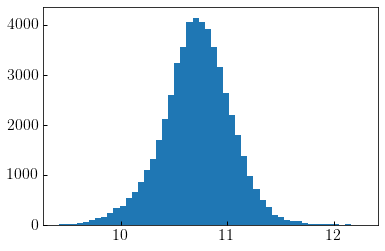

In [95]:
mask = mock['mag_r_obs'] < 22
mask *= mock['redshift'] > 0.75
np.count_nonzero(mask)

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(mock['mstar'][mask]), bins=50)